In [ ]:
# Install library untuk membaca file Excel jika belum ada
!pip install openpyxl

# Import library yang diperlukan
import pandas as pd

# Unggah file ke Google Colab
from google.colab import files

print("Unggah file data_ready_final_v2.xlsx")
uploaded_excel = files.upload()

print("Unggah file hasil_klasifikasi.csv")
uploaded_csv = files.upload()

# Baca file Excel dan CSV
data_ready = pd.read_excel("data_ready_final_v2.xlsx")  # Sesuaikan sheet jika diperlukan
hasil_klasifikasi = pd.read_csv("hasil_klasifikasi.csv")

# Lakukan penggabungan berdasarkan kolom "judul" dan "Judul"
merged_data = data_ready.merge(
    hasil_klasifikasi[['Judul', 'Kategori']],
    left_on='judul',
    right_on='Judul',
    how='left'
)

# Drop kolom "Judul" dari hasil merge (opsional, jika tidak dibutuhkan)
merged_data.drop(columns=['Judul'], inplace=True)

# Simpan hasil ke file Excel baru
output_file = "data_ready_with_kategori.xlsx"
merged_data.to_excel(output_file, index=False)

print(f"Hasil penggabungan telah disimpan ke {output_file}")
files.download(output_file)


Unggah file data_ready_final_v2.xlsx


Saving data_ready_final_v2.xlsx to data_ready_final_v2 (1).xlsx
Unggah file hasil_klasifikasi.csv


Saving hasil_klasifikasi.csv to hasil_klasifikasi (1).csv
Hasil penggabungan telah disimpan ke data_ready_with_kategori.xlsx


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

# Embedding dan Clustering Teks Berita Menggunakan Model BERT dan Visualisasi Cluster

Kode ini bertujuan untuk melakukan clustering pada teks berita menggunakan model BERT untuk menghasilkan embedding, diikuti dengan penerapan algoritma KMeans untuk mengelompokkan teks ke dalam beberapa cluster. Hasil clustering kemudian divisualisasikan menggunakan scatter plot setelah reduksi dimensi

In [ ]:
# Importing necessary libraries
from transformers import BertModel, BertTokenizer
from sklearn.cluster import KMeans
import torch
import numpy as np
import pandas as pd
import pickle

# Load data from Excel file
file_path = 'data_ready_with_kategori.xlsx'
data = pd.read_excel(file_path)

# Filter data to use the `text_berita` column for clustering
filtered_data = data[['text_berita']].dropna()

# Initialize BERT model and tokenizer
model_name = 'bert-base-uncased'
tokenizer = BertTokenizer.from_pretrained(model_name)
model = BertModel.from_pretrained(model_name)

# Function to get embeddings for each document
def get_bert_embeddings(text):
    inputs = tokenizer(text, return_tensors="pt", truncation=True, padding=True, max_length=128)
    outputs = model(**inputs)
    # Take the mean of the embeddings from the last hidden state as document embedding
    embeddings = outputs.last_hidden_state.mean(dim=1).detach().numpy()
    return embeddings.flatten()

# Compute embeddings for each document in `text_berita`
embeddings = np.array([get_bert_embeddings(text) for text in filtered_data['text_berita']])

# Save embeddings to a pickle file
nmfile = 'text_berita_embeddings.pkl'
with open(nmfile, 'wb') as file:
    pickle.dump(embeddings, file)
print("Embeddings berhasil disimpan ke file pickle.")

# Load embeddings from the pickle file (optional, for verification)
with open(nmfile, 'rb') as file:
    embeddings = pickle.load(file)
print("Embeddings berhasil dimuat dari file pickle.")

# Perform KMeans clustering
num_clusters = 5
kmeans = KMeans(n_clusters=num_clusters, random_state=42)
kmeans.fit(embeddings)
labels = kmeans.labels_

# Add cluster labels to the original DataFrame
filtered_data['cluster'] = labels

# Output results (displaying first 10 rows with text snippet and cluster label)
for idx, (text, label) in enumerate(zip(filtered_data['text_berita'][:10], labels[:10])):
    print(f"Document {idx} - Cluster {label}")
    print(f"Text: {text[:100]}...")  # Displaying a snippet of each text
    print("-" * 40)

# Save the DataFrame with cluster labels to a new Excel file
output_file = 'data_with_clusters.xlsx'
filtered_data.to_excel(output_file, index=False)
print(f"Data dengan cluster berhasil disimpan ke {output_file}.")


/usr/local/lib/python3.10/dist-packages/huggingface_hub/utils/_auth.py:94: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


tokenizer_config.json:   0%|          | 0.00/48.0 [00:00<?, ?B/s]

vocab.txt:   0%|          | 0.00/232k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/466k [00:00<?, ?B/s]

config.json:   0%|          | 0.00/570 [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/440M [00:00<?, ?B/s]

Embeddings berhasil disimpan ke file pickle.
Embeddings berhasil dimuat dari file pickle.
Document 0 - Cluster 2
Text: 
KOMPAS.com - Peserta program Jaminan Kesehatan Nasional (JKN) yang tidak mampu lagi membayar iuran ...
----------------------------------------
Document 1 - Cluster 2
Text: 

KOMPAS.com - Memindahkan fasilitas kesehatan (faskes) pertama Badan Penyelenggara Jaminan Sosial (...
----------------------------------------
Document 2 - Cluster 3
Text: 

JAKARTA, KOMPAS.com - Direktur Utama BPJS Kesehatan Ali Ghufron Mukti mengatakan, dokter asing yan...
----------------------------------------
Document 3 - Cluster 2
Text:  

KOMPAS.com - Direktur Pelayanan Badan Penyelenggaraan Jaminan Sosial (BPJS) Ketenagakerjaan Roswi...
----------------------------------------
Document 4 - Cluster 2
Text: 
KOMPAS.com   Deputi Direksi Bidang Jaminan Pembiayaan Pelayanan Primer Badan Penyelenggara Jaminan...
----------------------------------------
Document 5 - Cluster 2
Text: 

KOMPAS.co

# Visualisasi PCA

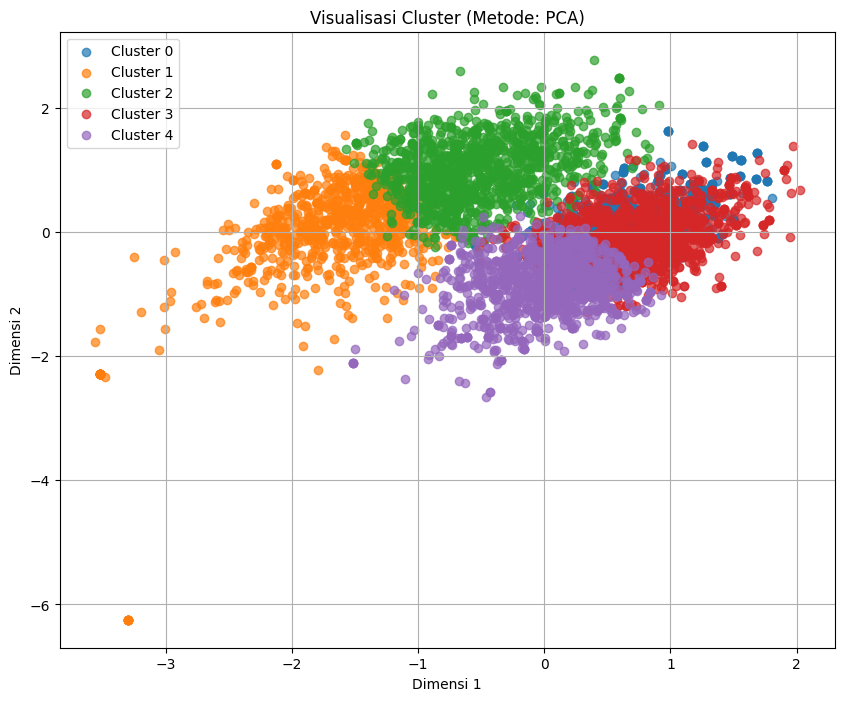

In [ ]:
import matplotlib.pyplot as plt
from sklearn.decomposition import PCA
from sklearn.manifold import TSNE

# Pilih metode reduksi dimensi: PCA atau t-SNE
def reduce_dimensions(embeddings, method='pca', n_components=2):
    if method == 'pca':
        reducer = PCA(n_components=n_components)
    elif method == 'tsne':
        reducer = TSNE(n_components=n_components, random_state=42, perplexity=30)
    else:
        raise ValueError("Metode reduksi dimensi tidak valid. Gunakan 'pca' atau 'tsne'.")

    reduced_embeddings = reducer.fit_transform(embeddings)
    return reduced_embeddings

# Reduksi dimensi embeddings menjadi 2D
method = 'pca'  # Ganti ke 'tsne' jika ingin menggunakan t-SNE
reduced_embeddings = reduce_dimensions(embeddings, method=method)

# Visualisasi scatter plot hasil clustering
plt.figure(figsize=(10, 8))
for cluster in range(num_clusters):
    cluster_points = reduced_embeddings[filtered_data['cluster'] == cluster]
    plt.scatter(cluster_points[:, 0], cluster_points[:, 1], label=f'Cluster {cluster}', alpha=0.7)

plt.title(f'Visualisasi Cluster (Metode: {method.upper()})')
plt.xlabel('Dimensi 1')
plt.ylabel('Dimensi 2')
plt.legend()
plt.grid(True)
plt.show()
